# Business problem:  Identify  which  factors  predict  future  user adoption 

### Who are the adopted users?
**Adopted  user:**   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven day  period.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. user engagement table

### A  usage  summary  table  has  a  row  for  each  day that  a  user  logged  into  the  product.

  **adopted  user:**   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven day  period.
  
Identify  which  factors  predict  future  user adoption .


In [2]:
user_eng = pd.read_csv('takehome_user_engagement.csv')
print(user_eng.shape)
user_eng.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
user_eng.time_stamp.min(), user_eng.time_stamp.max()

('2012-05-31 08:20:06', '2014-06-06 14:58:50')

In [4]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
user_eng.visited.value_counts(normalize= True)

1    1.0
Name: visited, dtype: float64

**All values of 'visited' column is one.**

In [6]:
#convert the datatype of time_stamp from object to datetime and extract only date not time 
user_eng['time_stamp']= user_eng['time_stamp'].apply(lambda x: pd.to_datetime(x, format= '%Y-%m-%d').date())
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22,1,1
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1


In [7]:
#groupby userid and date
user_eng= pd.DataFrame(user_eng.groupby(['user_id', 'time_stamp'])['visited'].sum())
user_eng.head()

visited
user_id time_stamp         
1       2014-04-22        1
2       2013-11-15        1
        2013-11-29        1
        2013-12-09        1
        2013-12-25        1

In [8]:
user_eng.visited.describe()

count    207917.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: visited, dtype: float64

**All users visited the product only one time in each login date.**

In [9]:
user_eng.reset_index(inplace=True)

In [10]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     207917 non-null  int64 
 1   time_stamp  207917 non-null  object
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [11]:
user_eng['time_stamp']= user_eng['time_stamp'].apply(lambda x: pd.to_datetime(x, format= '%Y-%m-%d').date())
user_eng.head()

,user_id,time_stamp,visited
0,1,2014-04-22,1
1,2,2013-11-15,1
2,2,2013-11-29,1
3,2,2013-12-09,1
4,2,2013-12-25,1


### Check the users with 3 or more logged-in times and find those with 3 logged-in times in at least 7-days  period and label as adopted.

In [12]:
def is_adopted(df_login):
    n_login= len(df_login)
    
    if n_login <3:
        return 0
    else:
        for i in np.arange(n_login - 2):
            if df_login.iloc[i+2] - df_login.iloc[i] < pd.Timedelta(7,'D'):
                return 1
    return 0        

In [13]:
user_adoption = user_eng.groupby('user_id')[['time_stamp']].agg(is_adopted)
user_adoption.reset_index(inplace= True)
user_adoption.columns= ['user_id','adopted']
user_adoption.head()

,user_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


### Find the last logged-in date for each user

In [14]:
user_adoption['last_session']= user_eng.groupby('user_id')['time_stamp'].transform('max')
user_adoption.head()

,user_id,adopted,last_session
0,1,0,2014-04-22
1,2,1,2014-03-31
2,3,0,2014-03-31
3,4,0,2014-03-31
4,5,0,2014-03-31


----------------

# 2. Users table

### user  table with  data  on  12,000  users  who  signed  up  for  the product  in  the  last  two  years.   This  table  includes:

● name:  the  user's  name

● object_id:   the  user's  id

● email:  email  address

● creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:

    ○ PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
    
    ○ GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
    
    ○ ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
    
    ○ SIGNUP:  signed  up  via  the  website
    
    ○ SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication(using  a  Google  email  account  for  their  login id)
    
● creation_time:  when  they  created  their  account

● last_session_creation_time:   unix  timestamp  of  last  login

● opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails

● enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip

● org_id:  the  organization  (group  of  users)  they  belong  to

● invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).


drip campaign/ drip marketing /automated email campaign: 

they're a set of marketing emails that will be sent out automatically on a schedule.

In [15]:
users = pd.read_csv('takehome_users.csv', encoding="ISO-8859-1")
print(users.shape)
users.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


### How many unique user_id are there?

In [17]:
users.drop_duplicates(inplace= True)
users.shape

(12000, 10)

In [18]:
users.rename(columns= {'object_id':'user_id'}, inplace= True)
users.user_id.nunique()

12000

### There are 12000 unique user id.

# 3. Merge Datasets

In [19]:
df = user_adoption.merge(users, on='user_id', how= 'outer')
print(df.shape)
df.head()

(12000, 12)


,user_id,adopted,last_session,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,0.0,2014-04-22,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,1.0,2014-03-31,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,0.0,2014-03-31,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,0.0,2014-03-31,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,0.0,2014-03-31,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


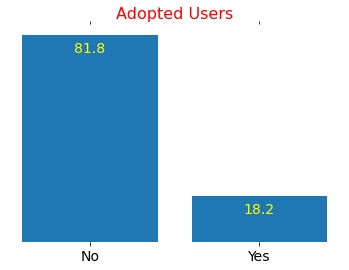

In [20]:
user_segmentation = round(100 *user_adoption.adopted.value_counts(normalize= True, dropna= False),1)
user_segmentation = pd.DataFrame(user_segmentation).reset_index()
user_segmentation.columns = ['adopted', 'percentage']
user_segmentation.adopted.replace({1: 'Yes', 0: "No"}, inplace=True)

bars= plt.bar(x= user_segmentation.adopted, height= user_segmentation.percentage)
    
for spine in plt.gca().spines.values():
    spine.set_visible (False)

plt.tick_params (top='off', bottom='off', left=False , right=False, labelleft=False, labelbottom='on')

#direct label each bar with Y axis values
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height()-7,
                   bar.get_height().round(2), ha='center', color='yellow', fontsize=14) 
    

plt.xticks(fontsize=14)
plt.title('Adopted Users', fontsize=16,color='red')
plt.show()

### This is a highly imbalanced dataset

----------

# 4. Exploration

In [21]:
df.loc[df.adopted.isna(),['user_id', 'last_session_creation_time', 'last_session', 'adopted']].isnull().sum()

user_id                          0
last_session_creation_time    3177
last_session                  3177
adopted                       3177
dtype: int64

In [22]:
len(df[df.last_session_creation_time.isnull()])

3177

In [23]:
len(df[df.adopted == 1])

1602

#### From 12000 users who signed up, 3177 of them didn't have logged-in for any session. From the remaining 8823 users who created session at least one time, only 1602 has adopted.

In [24]:
df.loc[df.last_session_creation_time.isnull(), 'adopted'] =0

### Label the user_id based on if they have created any session or not

In [25]:
df['session'] = df['last_session_creation_time'].apply(lambda x: True if x>0 else False)
df['session']= df['session'].astype(int)

### Column 'last_session_creation_time' is Unix time stamp. Let's convert it to date time. 

In [26]:
#Covert the datatype of creation_time to datetime
df['creation_time']= df['creation_time'].apply(lambda x: pd.to_datetime(x))
df['last_session_creation_time']= df['last_session_creation_time']\
                                    .apply(lambda x: pd.to_datetime(x, unit='s', origin='unix'))
df.head()

,user_id,adopted,last_session,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,session
0,1,0.0,2014-04-22,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1
1,2,1.0,2014-03-31,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,0.0,2014-03-31,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1
3,4,0.0,2014-03-31,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1
4,5,0.0,2014-03-31,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1


Last logged-in session from user_engagement table is the same as last_session_creation_time in users table.

### How long did each user log in the product?

In [27]:
df['timedelta_lastsession_signup']= df[['creation_time', 'last_session_creation_time']]\
    .apply(lambda x: pd.Timedelta((x[1]-x[0]), 'days').days, axis=1)

df.drop(columns= ['creation_time', 'last_session_creation_time'], inplace= True)



C:\Users\bahra\Anaconda\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\bahra\Anaconda\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


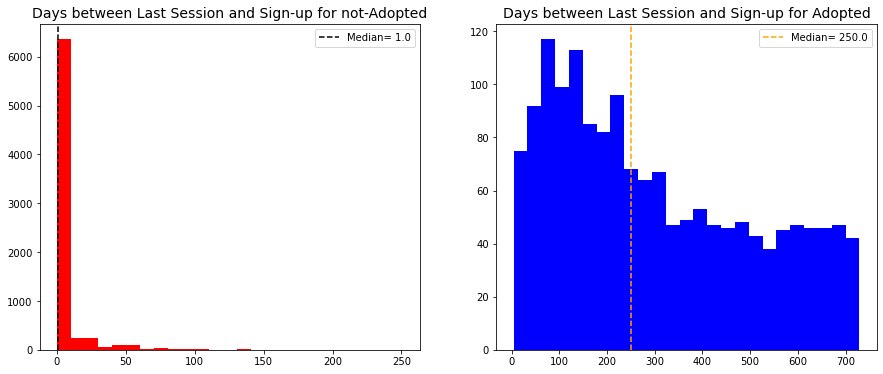

In [28]:
plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1,2),(0,0))
ax2 = plt.subplot2grid((1,2),(0,1))

ax1.hist(df.loc[df.adopted == 0, 'timedelta_lastsession_signup'], bins=25, color='red')
ax1.set_title('Days between Last Session and Sign-up for not-Adopted', size=14)
ax1.axvline(df.loc[df.adopted == 0, 'timedelta_lastsession_signup'].median(), c='black', linestyle='--'\
           , label= 'Median= {}'.format(df.loc[df.adopted == 0, 'timedelta_lastsession_signup'].median()))
ax1.legend()

ax2.hist(df.loc[df.adopted == 1, 'timedelta_lastsession_signup'], bins=25, color='blue')
ax2.axvline(df.loc[df.adopted == 1, 'timedelta_lastsession_signup'].median(), c='orange', linestyle='--'\
           , label= 'Median= {}'.format(df.loc[df.adopted == 1, 'timedelta_lastsession_signup'].median()))
ax2.set_title('Days between Last Session and Sign-up for Adopted', size=14)


ax2.legend()
plt.show()

### 50% of not-adopted users logged-in for the last time within first 2 days after their sign up. Bu, last logged-in of 50% of adopted users happened within 250 days after their sign up date.

The greatest time delta is more than 700, let's fill null values with 1500:

In [29]:
df['timedelta_lastsession_signup'].fillna(value= 1500, inplace= True)

### Did invitation by other user influence the user adoption?

In [30]:
df['invited'] = df.invited_by_user_id.notna().astype(int)

In [31]:
adop_invt = round(100 * df.groupby('adopted')['invited'].value_counts(normalize= True), 1)
adop_invt = pd.DataFrame(adop_invt)
adop_invt.columns= ['percentage']
adop_invt.reset_index(inplace= True)
adop_invt

,adopted,invited,percentage
0,0.0,1,52.9
1,0.0,0,47.1
2,1.0,1,57.0
3,1.0,0,43.0


In [32]:
adop_invt= pd.pivot_table(adop_invt, index=['adopted'], columns=['invited'], values= 'percentage' )
adop_invt.reset_index(inplace=True)
adop_invt.columns= ['adopted','not_invited','invited']
adop_invt

,adopted,not_invited,invited
0,0.0,47.1,52.9
1,1.0,43.0,57.0


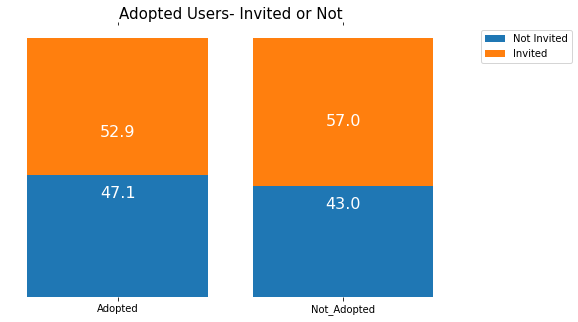

In [33]:
plt.figure(figsize=(8,5))

bars = plt.bar(x= adop_invt.adopted, height= adop_invt.not_invited, label= 'Not Invited')
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height()-9,
                   bar.get_height().round(2), ha='center', color='white', fontsize= 16)

    


bars = plt.bar(x=adop_invt.adopted, height= adop_invt.invited, bottom= adop_invt.not_invited, label= 'Invited')
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height()+9,
                   bar.get_height().round(2), ha='center', color='white', fontsize= 16)
    
    
    
for spine in plt.gca().spines.values():
    spine.set_visible (False)
    
plt.tick_params (top='off', bottom='off', left=False , right=False, labelleft=False, labelbottom='on')    

plt.xticks(adop_invt.adopted, ['Adopted', 'Not_Adopted'])
plt.title('Adopted Users- Invited or Not',fontsize=15, c='black')
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
plt.show()

### Almost 57% of not adopted users were invited by other users.

In [34]:
invited = round(100 * df.groupby('invited')['adopted'].value_counts(normalize= True), 2)
invited = pd.DataFrame(invited)
invited.columns= ['percentage']
invited.reset_index(inplace=True)
invited

,invited,adopted,percentage
0,0,0.0,87.66
1,0,1.0,12.34
2,1,0.0,85.77
3,1,1.0,14.23


In [35]:
invited= pd.pivot_table(invited, index=['invited'], columns=['adopted'], values= 'percentage' )
invited.reset_index(inplace=True)
invited.columns= ['invited','not_adopted','adopted']
invited

,invited,not_adopted,adopted
0,0,87.66,12.34
1,1,85.77,14.23


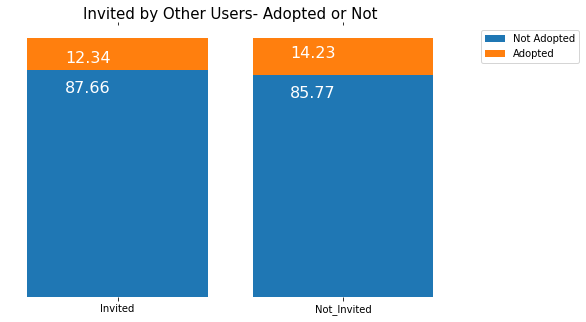

In [36]:
plt.figure(figsize=(8,5))



bars = plt.bar(x= invited.invited, height= invited.not_adopted, label= 'Not Adopted')
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/3 , bar.get_height()-9,
                   bar.get_height().round(2), ha='center', color='white', fontsize= 16)

    

bars = plt.bar(x=invited.invited, height= invited.adopted, bottom= invited.not_adopted, label= 'Adopted')
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/3 , bar.get_height()+78,
                   bar.get_height().round(2), ha='center', color='white', fontsize= 16)
    
    
    
for spine in plt.gca().spines.values():
    spine.set_visible (False)
    
plt.tick_params (top='off', bottom='off', left=False , right=False, labelleft=False, labelbottom='on')    

plt.xticks(invited.invited, ['Invited','Not_Invited'])
plt.title('Invited by Other Users- Adopted or Not',fontsize=15, c='black')
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))

plt.show()

### Only 12% of invited users were adopted, while almost 14% of not-invted users were adopted.
### Self-motivated users were more adopted than users invited by other users.

In [37]:
df.drop(columns= ['invited_by_user_id'], inplace= True)

### What are the dominant email domain?

In [38]:
round(100 * df['email'].apply(lambda x: x.split('@')[-1]).value_counts(normalize= True, ascending= False),2).head(7)

gmail.com         29.68
yahoo.com         20.39
jourrapide.com    10.49
cuvox.de          10.02
gustr.com          9.83
hotmail.com        9.71
dqwln.com          0.02
Name: email, dtype: float64

#### The gmail.com, yahoo.com, jourrapide.com, cuvox.de, gustr.com, hotmail.com are main domains. The other domains have low proportions so let's put them in 'other' category.

In [39]:
domain_lst= ['gmail', 'yahoo', 'jourrapide', 'cuvox', 'gustr', 'hotmail']
df['email_domain']= df['email'].apply(\
            lambda x: x.split('@')[-1].split('.')[0] if x.split('@')[-1].split('.')[0] in domain_lst else 'other' )

df['email_domain'].unique()

array(['yahoo', 'gustr', 'jourrapide', 'cuvox', 'gmail', 'other',
       'hotmail'], dtype=object)

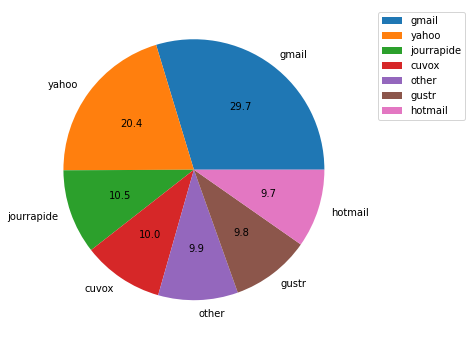

In [40]:
domain_share = round(100 * df.email_domain.value_counts(normalize=True),2)

plt.figure(figsize=(6,6))
plt.pie(domain_share, labels= domain_share.index, autopct= '%1.1f')
plt.legend(loc= 'upper left', bbox_to_anchor= (1.05,1))
plt.show()

In [41]:
email_domain = round(100 * df.groupby(['email_domain'])['adopted'].value_counts(normalize= True),2)
email_domain = pd.DataFrame(email_domain)
email_domain.columns = ['percentage']
email_domain.reset_index(inplace= True)
email_domain.head()

,email_domain,adopted,percentage
0,cuvox,0.0,88.52
1,cuvox,1.0,11.48
2,gmail,0.0,84.76
3,gmail,1.0,15.24
4,gustr,0.0,87.87


In [42]:
email_domain = pd.pivot_table(email_domain, index= 'email_domain', columns= ['adopted'], values= 'percentage')
email_domain.reset_index(inplace= True)
email_domain.columns= ['domain', 'not_adopted', 'adopted']
email_domain = email_domain.sort_values(by='adopted', ascending= True)
email_domain

,domain,not_adopted,adopted
6,yahoo,89.33,10.67
0,cuvox,88.52,11.48
2,gustr,87.87,12.13
4,jourrapide,87.05,12.95
5,other,86.76,13.24
1,gmail,84.76,15.24
3,hotmail,83.09,16.91


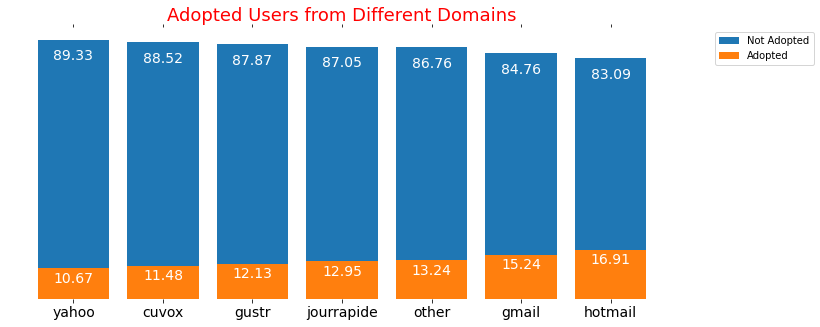

In [43]:
plt.figure(figsize=(12,5))
bars = plt.bar(x= email_domain.domain, height= email_domain.not_adopted, label= 'Not Adopted')
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height()-7,
                   bar.get_height().round(2), ha='center', color='white', fontsize=14) 
    
    
    
bars = plt.bar(x= email_domain.domain, height= email_domain.adopted, label= 'Adopted') 
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height()-5,
                   bar.get_height().round(2), ha='center', color='white', fontsize=14) 
    

for spine in plt.gca().spines.values():
    spine.set_visible (False)

plt.tick_params (top='off', bottom='off', left=False , right=False, labelleft=False, labelbottom='on') 
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
plt.title('Adopted Users from Different Domains', color='red', fontsize=18)
plt.xticks(fontsize=14)
plt.show()    

### About one third of adopted users used hotmail and gmail.

In [44]:
encoded = pd.get_dummies(df['email_domain'], prefix= 'email_domain')
df = pd.concat([df, encoded], axis= 1).drop(columns= ['email_domain'])
df.head(2)

,user_id,adopted,last_session,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,session,timedelta_lastsession_signup,invited,email_domain_cuvox,email_domain_gmail,email_domain_gustr,email_domain_hotmail,email_domain_jourrapide,email_domain_other,email_domain_yahoo
0,1,0.0,2014-04-22,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,1,0.0,1,0,0,0,0,0,0,1
1,2,1.0,2014-03-31,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,1,136.0,1,0,0,1,0,0,0,0


### What are the dominant creation_source?

In [45]:
round(100 *df['creation_source'].value_counts(normalize= True, dropna= False, ascending= False),2)

ORG_INVITE            35.45
GUEST_INVITE          18.02
PERSONAL_PROJECTS     17.59
SIGNUP                17.39
SIGNUP_GOOGLE_AUTH    11.54
Name: creation_source, dtype: float64

In [46]:
adopt_source = pd.DataFrame(round(100 * df.groupby(['adopted'])['creation_source'].value_counts(normalize= True), 2))
adopt_source.columns= ['pct']
adopt_source.reset_index(inplace=True)
adopt_source

,adopted,creation_source,pct
0,0.0,ORG_INVITE,35.59
1,0.0,PERSONAL_PROJECTS,18.72
2,0.0,GUEST_INVITE,17.34
3,0.0,SIGNUP,17.25
4,0.0,SIGNUP_GOOGLE_AUTH,11.09
5,1.0,ORG_INVITE,34.52
6,1.0,GUEST_INVITE,22.47
7,1.0,SIGNUP,18.29
8,1.0,SIGNUP_GOOGLE_AUTH,14.48
9,1.0,PERSONAL_PROJECTS,10.24


In [47]:
adopt_source = pd.pivot_table(adopt_source, index= 'adopted', columns= ['creation_source'], values= 'pct')
adopt_source.reset_index(inplace= True)
adopt_source

creation_source,adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,0.0,17.34,35.59,18.72,17.25,11.09
1,1.0,22.47,34.52,10.24,18.29,14.48


In [48]:
adopt_source = adopt_source.T
adopt_source.columns= ['Not_Adopted', 'Adopted']
adopt_source.reset_index(inplace= True)
adopt_source= adopt_source[adopt_source.creation_source != 'adopted']
adopt_source.sort_values(by='Adopted', ascending= False, inplace= True)
adopt_source

,creation_source,Not_Adopted,Adopted
2,ORG_INVITE,35.59,34.52
1,GUEST_INVITE,17.34,22.47
4,SIGNUP,17.25,18.29
5,SIGNUP_GOOGLE_AUTH,11.09,14.48
3,PERSONAL_PROJECTS,18.72,10.24


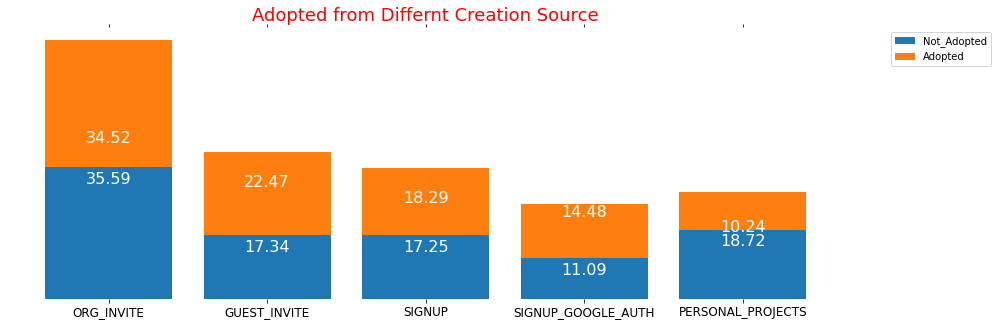

In [49]:
plt.figure(figsize=(15,5))


bars= plt.bar(x= adopt_source.creation_source, height= adopt_source.Not_Adopted, label= 'Not_Adopted')
for bar in bars:
        plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height()-4.5,
                   bar.get_height().round(2), ha='center', color='white', fontsize= 16)



bars= plt.bar(x= adopt_source.creation_source, height= adopt_source.Adopted, bottom= adopt_source.Not_Adopted, label= 'Adopted')
for bar in bars:
        plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height()+7.8,
                   bar.get_height().round(2), ha='center', color='white', fontsize= 16)
    
    
    
for spine in plt.gca().spines.values():
    spine.set_visible (False)
    
plt.tick_params (top='off', bottom='off', left=False , right=False, labelleft=False, labelbottom='on')  
plt.legend(loc= 'upper left', bbox_to_anchor= (1.05,1))
plt.xticks(fontsize= 12)
plt.title('Adopted from Differnt Creation Source', fontsize= 18, color='red')
plt.show()
    

### More than 75% of adopted users created their accounts through invited  to  an  organization  (as  a  full  member), invited  to  an  organization  as  a  guest (limited  permissions) and signed  up  via  the  website.

In [50]:
encoded = pd.get_dummies(users['creation_source'], prefix= 'creation_source')
df = pd.concat([df, encoded], axis= 1).drop(columns= ['creation_source'])
df.head(2)

,user_id,adopted,last_session,name,email,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,session,timedelta_lastsession_signup,...,email_domain_gustr,email_domain_hotmail,email_domain_jourrapide,email_domain_other,email_domain_yahoo,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0.0,2014-04-22,Clausen August,AugustCClausen@yahoo.com,1,0,11,1,0.0,...,0,0,0,0,1,1,0,0,0,0
1,2,1.0,2014-03-31,Poole Matthew,MatthewPoole@gustr.com,0,0,1,1,136.0,...,1,0,0,0,0,0,1,0,0,0


### Set the type of org_id as category

In [51]:
df.org_id = df.org_id.astype('category')
df.org_id.nunique()

417

**There are 417 unique values, so need especial encoding scheme.**

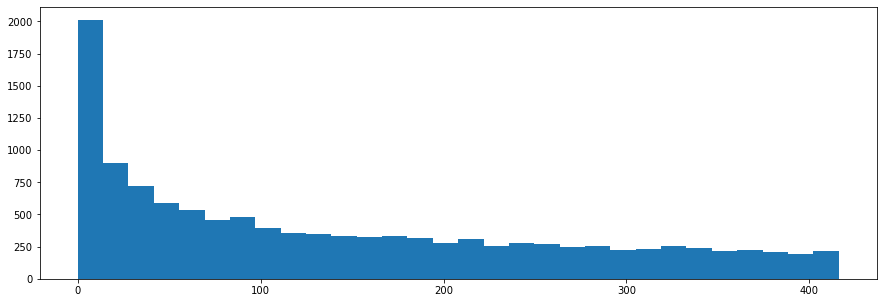

In [52]:
plt.figure(figsize=(15,5))
plt.hist(df.org_id, bins=30)
plt.show()

In [53]:
(df.org_id.value_counts() >= 120).sum()

8

### Only 8 organizations have one percent or more frequency (12000/100= 120).

In [54]:
org = pd.DataFrame(df.org_id.value_counts().head(8)).reset_index()
org.columns= ['org_id','freq']
org

,org_id,freq
0,0,319
1,1,233
2,2,201
3,3,168
4,4,159
5,6,138
6,5,128
7,9,124


In [55]:
lst_id= list(org.org_id)
lst_id

[0, 1, 2, 3, 4, 6, 5, 9]

In [56]:
lst_id= list(org.org_id)
df['freq_org_id'] = df.org_id.apply(lambda x: 1 if x in lst_id else(0))
df.drop(columns= ['org_id'], axis=0, inplace= True)
df['freq_org_id'].head()

0    0
1    1
2    0
3    1
4    0
Name: freq_org_id, dtype: int64

In [57]:
df.columns

Index(['user_id', 'adopted', 'last_session', 'name', 'email',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'session',
       'timedelta_lastsession_signup', 'invited', 'email_domain_cuvox',
       'email_domain_gmail', 'email_domain_gustr', 'email_domain_hotmail',
       'email_domain_jourrapide', 'email_domain_other', 'email_domain_yahoo',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'freq_org_id'],
      dtype='object')

In [58]:
df= df[['adopted', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'session',
       'timedelta_lastsession_signup', 'invited', 'email_domain_cuvox',
       'email_domain_gmail', 'email_domain_gustr', 'email_domain_hotmail',
       'email_domain_jourrapide', 'email_domain_other', 'email_domain_yahoo',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'freq_org_id']]

-----------

# 5. Feature Selection
Feature Selection is one of the key step in machine learning. 

* It reduces the computation time, and
* also may help in reducing over-fitting. 

There are several ways to select features like:

* RFE, 
* Boruta
* Genetic Algorithms

**Boruta** by default uses **random forest** although it works with other algorithms like **LightGBM, XGBoost** etc.

* It selects the features that actually have relationship with outcome variable. 
* The algorithm **reshuffles the data to create shadow features**. 
* It eliminates the features that have significantly worst importance than shadow ones.


**There are few limitations in the approach:**

* It is required to remove multicollinearity and missing values from data before running Boruta.

This package was built in R but is available in python as well.

https://medium.com/@vikeshsingh37/feature-selection-using-boruta-e5a3605ff161

In [59]:
df.isnull().sum()

adopted                               0
opted_in_to_mailing_list              0
enabled_for_marketing_drip            0
session                               0
timedelta_lastsession_signup          0
invited                               0
email_domain_cuvox                    0
email_domain_gmail                    0
email_domain_gustr                    0
email_domain_hotmail                  0
email_domain_jourrapide               0
email_domain_other                    0
email_domain_yahoo                    0
creation_source_GUEST_INVITE          0
creation_source_ORG_INVITE            0
creation_source_PERSONAL_PROJECTS     0
creation_source_SIGNUP                0
creation_source_SIGNUP_GOOGLE_AUTH    0
freq_org_id                           0
dtype: int64

### There is no missing value in cleaned dataset.

In [60]:
y= df['adopted']
X= df.drop(['adopted'], axis=1)

In [61]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,session,timedelta_lastsession_signup,invited,email_domain_cuvox,email_domain_gmail,email_domain_gustr,email_domain_hotmail,email_domain_jourrapide,email_domain_other,email_domain_yahoo,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,freq_org_id
0,1,0,1,0.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
1,0,0,1,136.0,1,0,0,1,0,0,0,0,0,1,0,0,0,1
2,0,0,1,0.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,1,1.0,1,0,0,0,0,0,0,1,1,0,0,0,0,1
4,0,0,1,5.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0


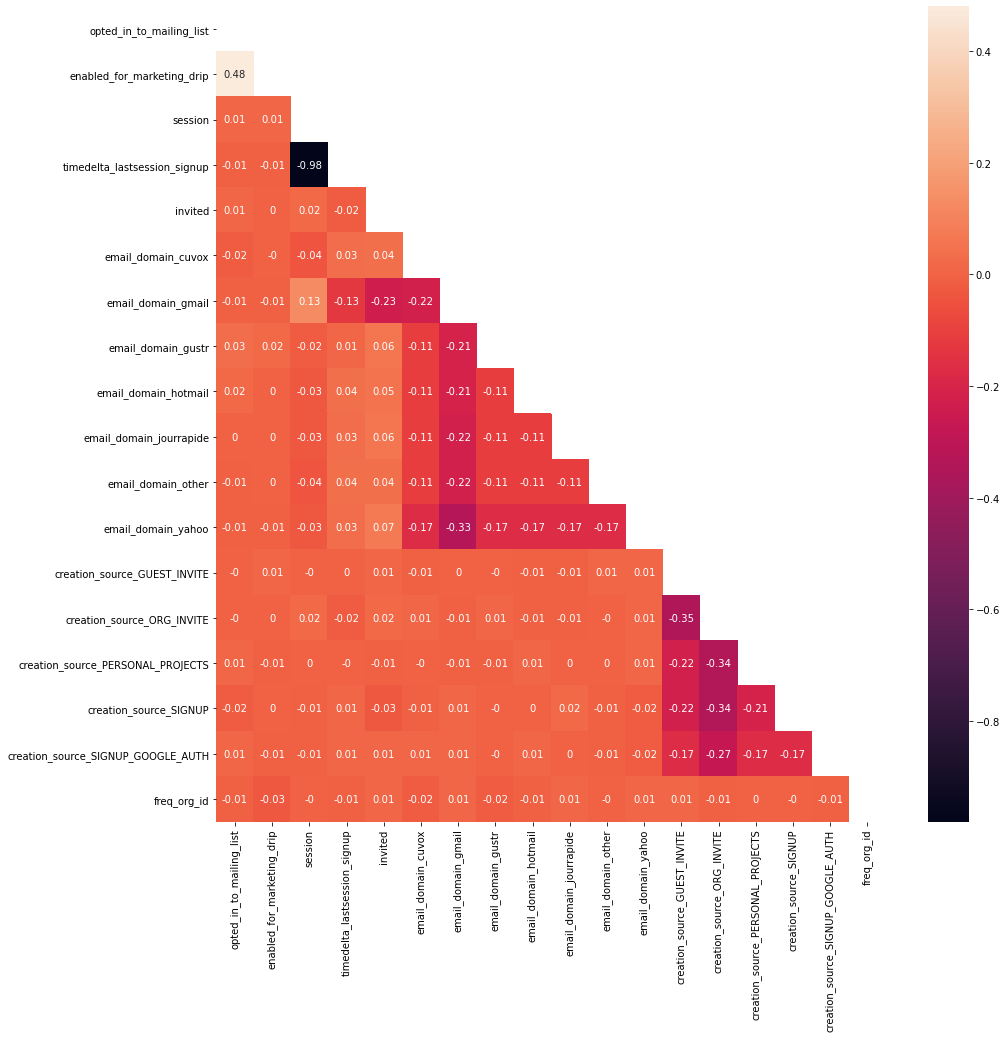

In [62]:
plt.figure(figsize=(15,15))
matrix = np.triu(X.corr())
sns.heatmap(round(X.corr(),2), annot= True, color='blue', mask= matrix)
plt.show()

timedelta_lastsession_signup is highly correlated with session feature, so let's drop timedelta_lastsession_signup.

In [63]:
df.drop(columns=['session'], inplace= True)
y= df['adopted']
X= df.drop(['adopted'], axis=1)

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

predictors = pd.DataFrame()

predictors['features'] = X.columns
predictors['VIF'] = [round(variance_inflation_factor(X.values, i),2) for i in range(len(X.columns))]
predictors

C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,features,VIF
0,opted_in_to_mailing_list,1.31
1,enabled_for_marketing_drip,1.31
2,timedelta_lastsession_signup,1.02
3,invited,1.06
4,email_domain_cuvox,inf
5,email_domain_gmail,inf
6,email_domain_gustr,inf
7,email_domain_hotmail,inf
8,email_domain_jourrapide,inf
9,email_domain_other,inf


### Now, there is no multicollinearity among main features, the infinity means there is high correlation among dummy variables which makes sense.

In [65]:
X= X.values
y= y.values

In [66]:
from sklearn.ensemble import RandomForestClassifier 
from boruta import BorutaPy

#instantiate a random forest classifier object
rf_clf = RandomForestClassifier(class_weight= 'balanced', random_state= 42, n_jobs= -1)  #run a numbr of jobs in parallel

#call boruta feature selection method
borut_fs = BorutaPy(rf_clf, n_estimators='auto', verbose= 1)  #control verbosity of output
borut_fs.fit(X,y)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	16


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=14, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x243E94E4840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x243E94E4840, verbose=1)

### What are the feature ranks?

In [67]:
rank= borut_fs.ranking_
features = df.drop(['adopted'], axis=1).columns

ranking_table = pd.DataFrame(rank, features).reset_index()
ranking_table.columns = ['Feature','Rank']
ranking_table =ranking_table.sort_values(by='Rank', ascending= True)
ranking_table 

,Feature,Rank
2,timedelta_lastsession_signup,1
3,invited,2
0,opted_in_to_mailing_list,3
16,freq_org_id,3
12,creation_source_ORG_INVITE,5
1,enabled_for_marketing_drip,6
5,email_domain_gmail,7
11,creation_source_GUEST_INVITE,8
14,creation_source_SIGNUP,9
13,creation_source_PERSONAL_PROJECTS,10


In [68]:
ranking_table.to_excel('ranking.xlsx',index=False)

### What do selected features tell?
If number of days between the signed up and last logged-in is high (median of 250 days), the user most probably converted into adopted user. If user has been invited by other user, it would increase the probability that the user would be adopted. If organization invited a user to create an account, especially organization with id in [0, 1, 2, 3, 4, 6, 5, 9], the user most probably will be adopted.
If user has been opted to receive marketing email, or signed up from gmail domain the probability of being adopted would be incresed. 
